In [1]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit_aer import AerSimulator
from matplotlib import pyplot as plt
from qiskit.providers.aer import QasmSimulator
import numpy as np
# qiskit-ibmq-provider has been deprecated.
# Please see the Migration Guides in https://ibm.biz/provider_migration_guide for more detail.
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

# Loading your IBM Quantum account(s)
service = QiskitRuntimeService(channel="ibm_quantum")

# Invoke a primitive inside a session. 
#For more details see https://qiskit.org/documentation/partners/qiskit_ibm_runtime/tutorials.html
# with Session(backend=service.backend("ibmq_qasm_simulator")):
#     result = Sampler().run(circuits).result()

In [2]:
sv_sim = Aer.get_backend('statevector_simulator')
qasm_sim = QasmSimulator(method='extended_stabilizer')

# Error free circuit

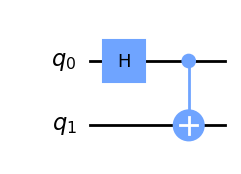

In [3]:
qc_no_error = QuantumCircuit(2)
qc_no_error.h(0)
qc_no_error.cx(0,1)
qc_no_error.draw()

Output state vector:
 Statevector([0.70710678+0.j, 0.        +0.j, 0.        +0.j,
             0.70710678+0.j],
            dims=(2, 2))


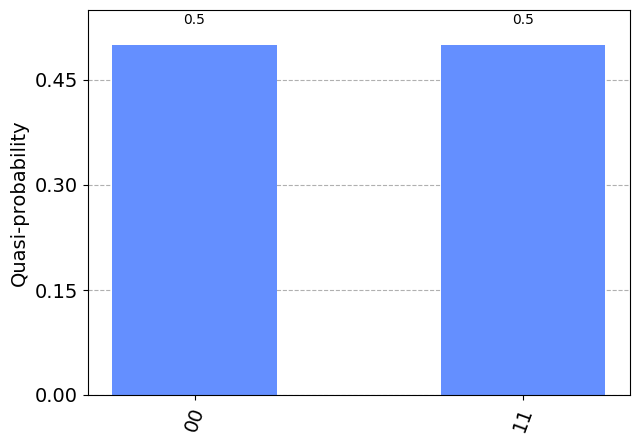

In [4]:
result_no_error = execute(qc_no_error,sv_sim).result()
print("Output state vector:\n", result_no_error.get_statevector())

counts = result_no_error.get_counts()
plot_histogram(counts)

In [5]:
%%latex
Without error the circuit behaves as above. But this is ideal scenario

<IPython.core.display.Latex object>

In [6]:
#adding pauli errors by inserting pauli gates
p_error = 0.3

def add_pauli_error(qubit, error_prob, pauli_errors):
    num_errors = len(pauli_errors)
    
    if (num_errors * error_prob > 1):
        raise ValueError('Total probability cannot be greater than 1. Reduce pauli_errors or error_prob')
    
    rand_num = np.random.uniform(0,1)
    
    for i in range(num_errors):
        if rand_num < (i+1)*error_prob:
            pauli_errors[i](qubit)
            return

#rand1 = np.random.uniform(0,1)
#print(rand1)

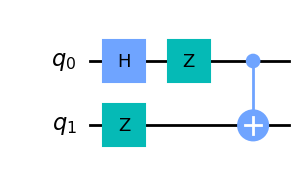

In [7]:
def gen_error_circuit(error_prob):
    qc_error = QuantumCircuit(2)
    qc_error.h(0)
    
    add_pauli_error(0,error_prob,[qc_error.x,qc_error.z])
    add_pauli_error(1,error_prob,[qc_error.x,qc_error.z])
    
    qc_error.cx(0,1)
    
    return qc_error

ckt = gen_error_circuit(p_error)
ckt.draw()

Output state vector:
 Statevector([ 0.70710678+0.00000000e+00j, -0.        +0.00000000e+00j,
             -0.        +0.00000000e+00j, -0.70710678-8.65956056e-17j],
            dims=(2, 2))


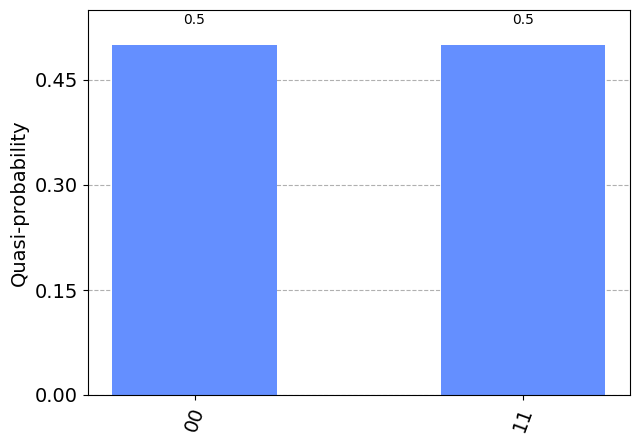

In [8]:
result_error = execute(ckt,sv_sim).result()
print("Output state vector:\n", result_error.get_statevector())

counts = result_error.get_counts()
plot_histogram(counts)

In [9]:
#multiple noisy circuits
N = 250

#expected state
phi = np.array([(1.0+0.0j)/np.sqrt(2),0.0j,0.0j,(1.0+0.0j)/np.sqrt(2)])
#print(phi)

prob_space = np.linspace(0,0.5,20)
#print(prob_space)

#measured fidelity values
fidelities = []

for p in prob_space:
    f = []
    for i in range(N):
        e_ckt = gen_error_circuit(p)
        psi = execute(e_ckt, sv_sim).result().get_statevector()
        
        f.append(np.abs(np.vdot(psi, phi))**2)
    fidelities.append(np.average(f))

#print(fidelities)

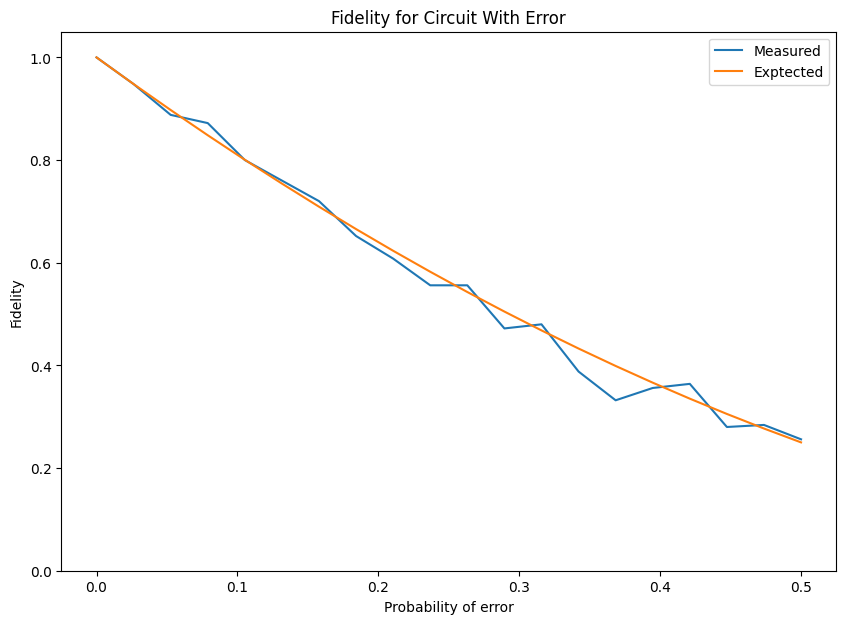

In [10]:
expected_fidelity = 1-2*prob_space+prob_space ** 2

#print(expected_fidelity)

fig = plt.figure(figsize=(10,7))

plt.title('Fidelity for Circuit With Error')

plt.plot(prob_space,fidelities,label='Measured')
plt.plot(prob_space,expected_fidelity,label='Exptected')

plt.xlabel('Probability of error')
plt.ylabel('Fidelity')

plt.ylim([0,1.05])

plt.legend()

In [11]:
%%latex
Start of steane code

<IPython.core.display.Latex object>

In [12]:
def steane_ec(qc, x_ancillas, z_ancillas, logical_qubit, x_syndrome, z_syndrome):
    #for this to work the inputs should be valid
    #we can add exceptions here. skipping for now
    
    #intialize the ancillas
    for i in range(3):
        qc.initialize([1,0], x_ancillas[i])
        qc.initialize([1,0], z_ancillas[i])
        
    # Apply Hadamard to the ancillas
    
    #qc.barrier()
    
    qc.h(z_ancillas)
    
    #qc.barrier()
    qc.cx(z_ancillas[0],[logical_qubit[i-1] for i in [1,3,5,7]])
    qc.cx(z_ancillas[1],[logical_qubit[i-1] for i in [2,3,6,7]])
    qc.cx(z_ancillas[2],[logical_qubit[i-1] for i in [4,5,6,7]])
    #qc.barrier()
    qc.h(z_ancillas)
    
    #qc.barrier()
    
    qc.h(x_ancillas)
    #qc.barrier()
    qc.cz(x_ancillas[0],[logical_qubit[i-1] for i in [1,3,5,7]])
    qc.cz(x_ancillas[1],[logical_qubit[i-1] for i in [2,3,6,7]])
    qc.cz(x_ancillas[2],[logical_qubit[i-1] for i in [4,5,6,7]])
    #qc.barrier()
    qc.h(x_ancillas)
   
    qc.barrier()
    #measure ancillas
    qc.measure(x_ancillas, x_syndrome)
    qc.measure(z_ancillas, z_syndrome)
    
    qc.barrier()
    # Apply the corrective X gates
    for i in range(1,8):
        qc.x(logical_qubit[i-1]).c_if(x_syndrome,i)
    
    #qc.barrier()
    # Apply the corrective Z gates
    for i in range(1,8):
        qc.z(logical_qubit[i-1]).c_if(z_syndrome,i)


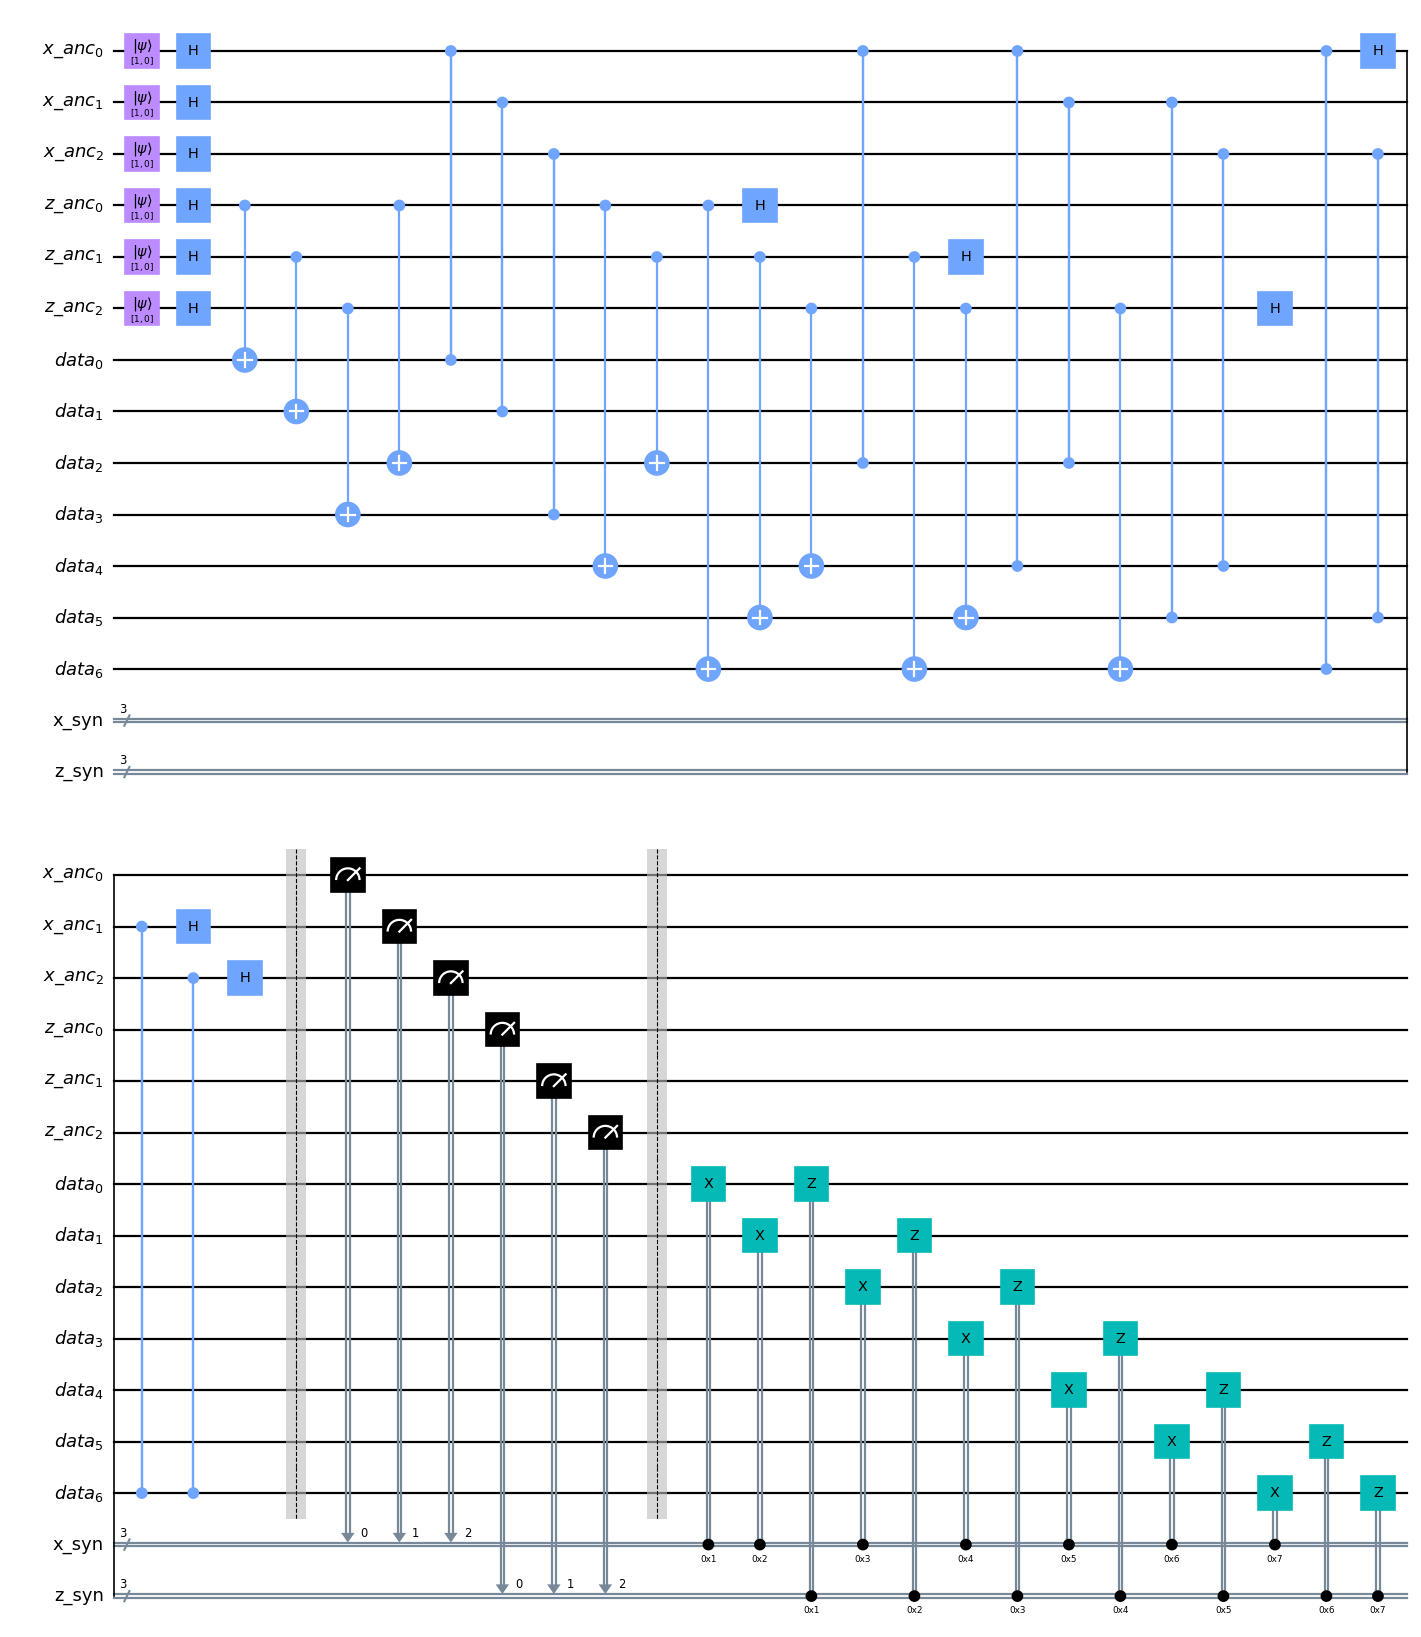

In [13]:
# Verifying that this error correction will generate the logical 0 state

data_q = QuantumRegister(7, name="data")
x_anc  = QuantumRegister(3, name="x_anc")
x_syn  = ClassicalRegister(3, name="x_syn")
z_anc  = QuantumRegister(3, name="z_anc")
z_syn  = ClassicalRegister(3, name="z_syn")

qc = QuantumCircuit(x_anc,z_anc,data_q,x_syn,z_syn)
steane_ec(qc, x_anc, z_anc, data_q, x_syn, z_syn)
qc.draw(scale=0.8)




In [14]:
result = execute(qc, sv_sim).result()
sv = np.asarray(result.get_statevector())

# list that holds the computational basis vector names where the amplitude is non-zero
indices = []       
for i in range(len(sv)):
    if sv[i] != 0:
        # store the index as a 10-bit long binary number
        indices.append( ((str(bin(i)[2:]).zfill(3+7)),sv[i]) )
        
print('Number of kets in superposition: ', len(indices))
print("Kets in superposition:")
for i in indices:
    print('Ket:', i[0][0:7][::-1], '--- Amplitude:', i[1] ) # Extract the 7 left-most bits of the number, 
                                                            # reverse them (for consistency with the notes)
                                                            # and print the amplitude of the ket

print('\nsqrt[1/8] =',np.sqrt(1/8))                        # To verify the amplitudes are correct

Number of kets in superposition:  8
Kets in superposition:
Ket: 1100000 --- Amplitude: (0.3535533905932738-6.494670421766199e-17j)
Ket: 1001111 --- Amplitude: (0.35355339059327373-1.515423098412113e-16j)
Ket: 0101101 --- Amplitude: (0.35355339059327373-1.515423098412113e-16j)
Ket: 0110011 --- Amplitude: (0.3535533905932738-1.5154230984121137e-16j)
Ket: 1101001 --- Amplitude: (0.35355339059327373-1.9484011265298595e-16j)
Ket: 1010101 --- Amplitude: (0.3535533905932738-1.0824450702943668e-16j)
Ket: 0110011 --- Amplitude: (0.3535533905932738-1.0824450702943665e-16j)
Ket: 0001111 --- Amplitude: (0.35355339059327373-1.0824450702943664e-16j)

sqrt[1/8] = 0.3535533905932738


In [15]:
#logical hadamard
def logical_h(qc, logical_q):
    qc.h(logical_q)

In [16]:
#logical CNOT i.e. tranversal
def logical_cx(qc, control, target):
    for i in range(7):
        qc.cx(control[i], target[i])

In [17]:
#measuring logical qubit in Z-basis
def z_measure(qc, anc, logical_q, meas):
    #Initialize ancilla
    qc.initialize([1,0], anc)
    
    qc.h(anc)
    
    for i in range(7):
        qc.cz(anc, logical_q[i])
    
    qc.h(anc)
    
    
    qc.measure(anc, meas)

In [18]:
#Encoded Bell circuit
def encoded_bell_circuit(error_prob=0, err_lvl=0):
    dataq_1 = QuantumRegister(7,name="data_1")
    dataq_2 = QuantumRegister(7,name="data_2")
    
    x_anc = QuantumRegister(3, name="x_anc")
    z_anc = QuantumRegister(3, name="z_anc")
    
    x_syn = ClassicalRegister(3, name="x_syn")
    z_syn = ClassicalRegister(3, name="z_syn")
    
    z_meas_anc1 = QuantumRegister(1, name="z_meas_anc1")
    z_meas_anc2 = QuantumRegister(1, name="z_meas_anc2")
    
    z_meas_1 = ClassicalRegister(1, name="meas_1")
    z_meas_2 = ClassicalRegister(1, name="meas_2")
    
    qc = QuantumCircuit(dataq_1, dataq_2, x_anc, z_anc, z_meas_anc1, z_meas_anc2, x_syn, z_syn, z_meas_1, z_meas_2)
    
    def introduce_error():
        if err_lvl==0:
            return
        elif err_lvl==1:
            qc.x(dataq_1[np.random.randint(0,7)])
            qc.z(dataq_1[np.random.randint(0,7)])

            qc.x(dataq_2[np.random.randint(0,7)])
            qc.z(dataq_2[np.random.randint(0,7)])
            return
        elif err_lvl==2:
            for i in range(7):
                add_pauli_error(dataq_1[i], error_prob, [qc.x, qc.z])
                add_pauli_error(dataq_2[i], error_prob, [qc.x, qc.z])
            return
    #intialize qec cycle
    steane_ec(qc, x_anc, z_anc, dataq_1, x_syn, z_syn)
    steane_ec(qc, x_anc, z_anc, dataq_2, x_syn, z_syn)
    
    logical_h(qc,dataq_1)
    introduce_error()
    #introduce_error(qc, dataq_1, dataq_2, err_lvl, error_prob)
    #hadamard qec cycle
    steane_ec(qc, x_anc, z_anc, dataq_1, x_syn, z_syn)
    steane_ec(qc, x_anc, z_anc, dataq_2, x_syn, z_syn)
    
    logical_cx(qc, dataq_1, dataq_2)
    introduce_error()
    #cnot qec cycle
    steane_ec(qc, x_anc, z_anc, dataq_1, x_syn, z_syn)
    steane_ec(qc, x_anc, z_anc, dataq_2, x_syn, z_syn)
    
    # Measure the qubits
    z_measure(qc, z_meas_anc1, dataq_1, z_meas_1)
    z_measure(qc, z_meas_anc2, dataq_2, z_meas_2)
    
    return qc

In [19]:
#qc = encoded_bell_circuit()
#qc.draw()

In [20]:
#Running the circuit with different error levels

In [21]:
N = 100
p_error = 0.1

# Error level 0

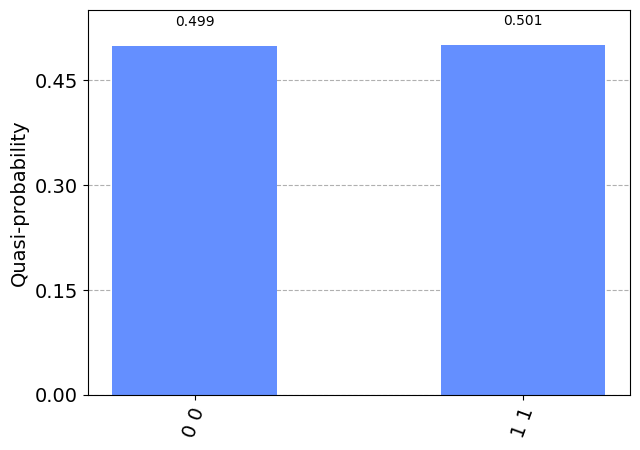

In [22]:
#Error level 0
net_counts = {}

for i in range(N):
    qc = encoded_bell_circuit(p_error, 0)
    
    result = execute(qc, qasm_sim).result()
    counts = result.get_counts()
    
    
    for key in counts.keys():
        # truncate the measurement string to include the Z-measurements
        truncated_key = key[0:3][::-1] # Reversed to match order dataq_1 dataq_2
        if truncated_key in net_counts.keys():
            net_counts[truncated_key] += counts[key]/1024
        else:
            net_counts[truncated_key] = counts[key]/1024
            
plot_histogram(net_counts)

# Error level 1

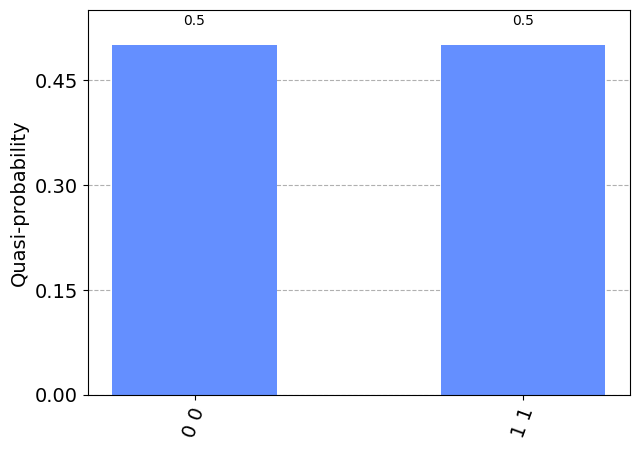

In [23]:
#error level 1
net_counts = {}

for i in range(N):
    qc = encoded_bell_circuit(p_error, 1)
    
    result = execute(qc, qasm_sim).result()
    counts = result.get_counts()
    
    for key in counts.keys():
        # truncate the measurement string to include the Z-measurements
        truncated_key = key[0:3][::-1] # Reversed to match order dataq_1 dataq_2
        if truncated_key in net_counts.keys():
            net_counts[truncated_key] += counts[key]/1024
        else:
            net_counts[truncated_key] = counts[key]/1024
            
plot_histogram(net_counts)

# Error level 2

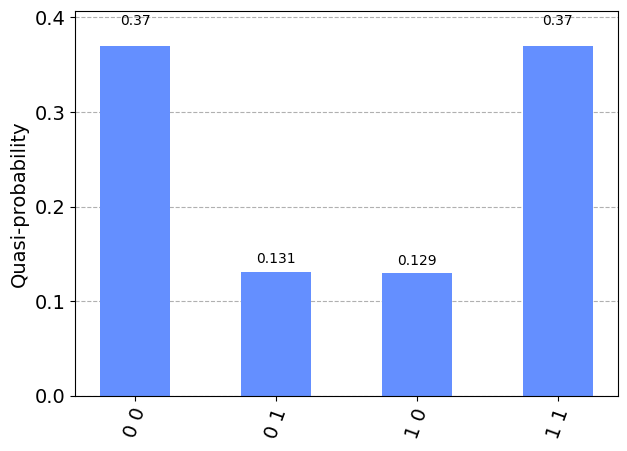

In [24]:
#error level 2
net_counts = {}

for i in range(N):
    qc = encoded_bell_circuit(p_error, 2)
    
    result = execute(qc, qasm_sim).result()
    counts = result.get_counts()
    
    for key in counts.keys():
        # truncate the measurement string to include the Z-measurements
        truncated_key = key[0:3][::-1] # Reversed to match order dataq_1 dataq_2
        if truncated_key in net_counts.keys():
            net_counts[truncated_key] += counts[key]/1024
        else:
            net_counts[truncated_key] = counts[key]/1024

            

plot_histogram(net_counts)